In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

BESS_CAPACITY = 50  # MWh
MAX_C_RATE = 0.5    # 0.5C (Max charge/discharge rate is 25 MW)
RT_AFRR_PRICE = 250 # €/MWh for aFRR service delivery (High value RT)
DA_ARBITRAGE_THRESHOLD = 0.1 # Arbitrage requires 10% deviation from avg price
HOURS = 24

In [2]:
# --- 1. Scenario Generation ---

def generate_stochastic_scenarios(base_prices, num_scenarios=10, vol_factor=0.15):
    """
    Generates multiple probabilistic price paths (scenarios) for a 24-hour period.
    The RT price uncertainty is linked to a simulated net energy imbalance error driver.
    """
    HOURS = len(base_prices)
    scenarios = pd.DataFrame(index=pd.to_datetime(np.arange(HOURS), unit='h'))
    
    # Simulate a Net Energy Forecast Error (this is the driver of RT price spikes)
    # Assume 10% of the mean price is driven by unpredictable imbalance
    NE_FORECAST_ERROR_DRIVER = base_prices.mean() * 0.1
    
    for s in range(num_scenarios):
        # 1. Base DA Price (minimal uncertainty)
        da_noise = np.random.normal(0, base_prices.mean() * vol_factor * 0.2, base_prices.shape)
        da_price_s = np.maximum(5, base_prices + da_noise)
        scenarios[f'DA_Price_s{s}'] = da_price_s
        
        # 2. Real-Time (RT) Price (High Uncertainty)
        # Create correlated price spikes based on simulated forecast error
        ne_error = np.random.normal(0, 1, HOURS) # Simulates a normally distributed net energy error
        
        # If NE error is large, the RT price deviates significantly from the DA price
        rt_price_volatility = NE_FORECAST_ERROR_DRIVER * ne_error * vol_factor
        rt_price_s = np.maximum(5, da_price_s + rt_price_volatility)
        
        scenarios[f'RT_Price_s{s}'] = rt_price_s
        
    # Assign equal probability to each scenario
    scenarios['Probability'] = 1 / num_scenarios
    
    return scenarios

In [3]:
# --- 2. Simplified Two-Stage Stochastic Solver ---

def solve_scenario_optimization(scenarios, capacity_reserved_rt):
    """
    Solves the BESS dispatch for the remaining capacity within a single scenario (Stage 2).
    """
    HOURS = scenarios.shape[0]
    
    # Capacity available for DA Arbitrage (MWh)
    capacity_arb = BESS_CAPACITY - capacity_reserved_rt
    
    # Max hourly power rate for Arbitrage (MW)
    P_arb_max = MAX_C_RATE * capacity_arb 
    
    scenario_profits = []
    
    scenario_cols = [col.split('_s')[1] for col in scenarios.columns if 'DA_Price' in col]
    
    for s_str in scenario_cols:
        s = int(s_str)
        
        DA_prices = scenarios[f'DA_Price_s{s_str}'].values
        RT_prices = scenarios[f'RT_Price_s{s_str}'].values 
        
        avg_DA_price = DA_prices.mean()
        
        # Initial SOC assumed at 50% for arbitrage capacity
        soc_arb = capacity_arb * 0.5
        total_arb_profit = 0
        
        # --- Stage 2: DA Arbitrage Dispatch ---
        # Dispatch decision is based on DA forecast (when to charge/discharge)
        # Profit/Cost is realized at the RT price (actual execution price)
        for hour in range(HOURS):
            price_da = DA_prices[hour]
            price_rt = RT_prices[hour]

            # Decision Logic: Use DA forecast to decide action
            if price_da < avg_DA_price * (1 - DA_ARBITRAGE_THRESHOLD) and soc_arb < capacity_arb:
                # Charge (Buy Low)
                charge_power = min(capacity_arb - soc_arb, P_arb_max)
                total_arb_profit -= charge_power * price_rt # Cost realized at RT price
                soc_arb += charge_power * 0.95 
                
            elif price_da > avg_DA_price * (1 + DA_ARBITRAGE_THRESHOLD) and soc_arb > 0:
                # Discharge (Sell High)
                discharge_power = min(soc_arb, P_arb_max)
                total_arb_profit += discharge_power * 0.95 * price_rt # Revenue realized at RT price
                soc_arb -= discharge_power
        
        # --- Stage 2: RT (aFRR) Revenue ---
        # Fixed revenue for reserving capacity * Price/MWh/h * 24 hours
        total_rt_profit = capacity_reserved_rt * RT_AFRR_PRICE * HOURS
        
        scenario_profits.append({
            'Scenario': s,
            'DA_Profit': total_arb_profit,
            'RT_Profit': total_rt_profit,
            'Total_Profit': total_arb_profit + total_rt_profit
        })

    return pd.DataFrame(scenario_profits)

# Helper function for the Main script to run the Stage 1 decision
def evaluate_expected_profit(scenarios, capacity_reserved_rt):
    """Calculates the expected profit (Stage 1 objective) across all scenarios."""
    
    scenario_results = solve_scenario_optimization(scenarios, capacity_reserved_rt)
    
    # Calculate Expected Profit: Sum(Probability * Total_Profit_s)
    num_scenarios = len(scenario_results)
    probability = 1 / num_scenarios
    
    expected_profit = (scenario_results['Total_Profit'] * probability).sum()
    
    return expected_profit, scenario_results

In [4]:
# --- 1. Base Price Forecast ---

def get_base_forecast(hours):
    """Generates a simple base price forecast curve."""
    # Synthetic data similar to previous steps
    X_hist = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
    y_hist = np.array([50, 75, 60, 90, 80, 110])
    model = LinearRegression().fit(X_hist, y_hist)
    
    X_forecast = np.arange(60, 60 + hours * 10, 10).reshape((-1, 1))
    base_prices = model.predict(X_forecast)
    return np.maximum(5, base_prices)

base_prices = get_base_forecast(HOURS)

In [5]:
# --- 2. Stochastic Optimization (Stage 1 Decision) ---

# Define the capacity steps to test for RT reservation
RESERVATION_STEPS = np.linspace(0, BESS_CAPACITY, 11) # Test 0, 5, 10, ..., 50 MWh

# Generate price scenarios
NUM_SCENARIOS = 10
VOLATILITY_FACTOR = 0.20 # 20% volatility for RT price

scenarios_df = generate_stochastic_scenarios(
    base_prices, num_scenarios=NUM_SCENARIOS, vol_factor=VOLATILITY_FACTOR
)

# Run the Stochastic Optimization (Iterate through reservation options)
optimization_results = []
for capacity_reserved in RESERVATION_STEPS:
    
    # Calculate expected profit for this reservation level
    expected_profit, scenario_profits_df = evaluate_expected_profit(scenarios_df, capacity_reserved)
    
    optimization_results.append({
        'Reserved_Capacity_MWh': capacity_reserved,
        'Expected_Profit': expected_profit,
        'Std_Dev_Profit': scenario_profits_df['Total_Profit'].std()
    })

optimization_df = pd.DataFrame(optimization_results)

# --- Find the Optimal Solution ---
optimal_row = optimization_df.loc[optimization_df['Expected_Profit'].idxmax()]
optimal_capacity_reserved = optimal_row['Reserved_Capacity_MWh']
optimal_expected_profit = optimal_row['Expected_Profit']

print("--- Stochastic Optimization Results ---")
print(f"BESS Capacity: {BESS_CAPACITY} MWh | RT (aFRR) Price: {RT_AFRR_PRICE} €/MWh")
print(f"Optimal Reserved Capacity (aFRR): {optimal_capacity_reserved:.2f} MWh")
print(f"Maximum Expected Daily Profit: {optimal_expected_profit:.2f} €")
print("-" * 50)

--- Stochastic Optimization Results ---
BESS Capacity: 50 MWh | RT (aFRR) Price: 250 €/MWh
Optimal Reserved Capacity (aFRR): 50.00 MWh
Maximum Expected Daily Profit: 300000.00 €
--------------------------------------------------



All stochastic optimization steps and graphs generated.
Generated file: bess_stochastic_full.py
Generated plots: stochastic_scenarios.png, stochastic_optimization_result.png


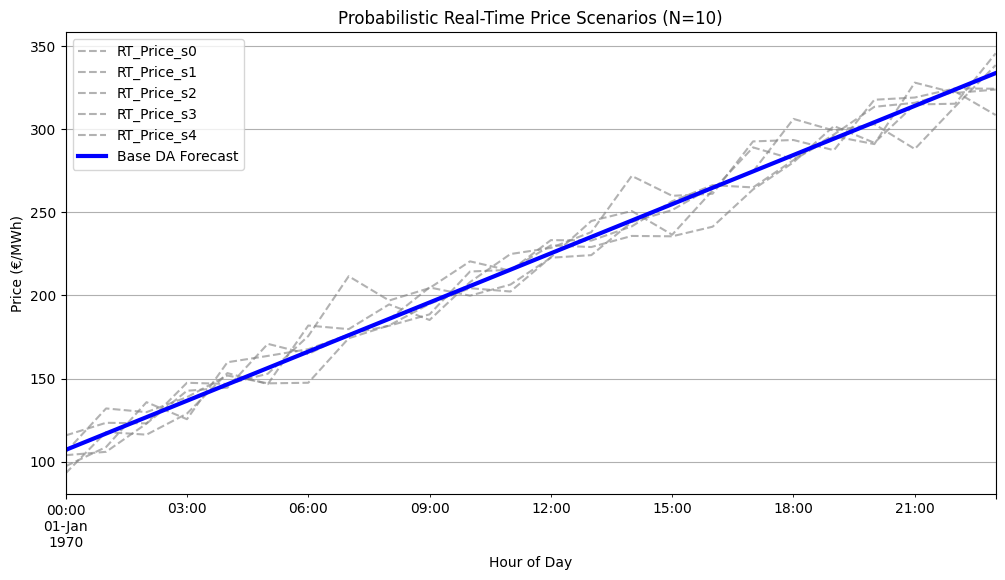

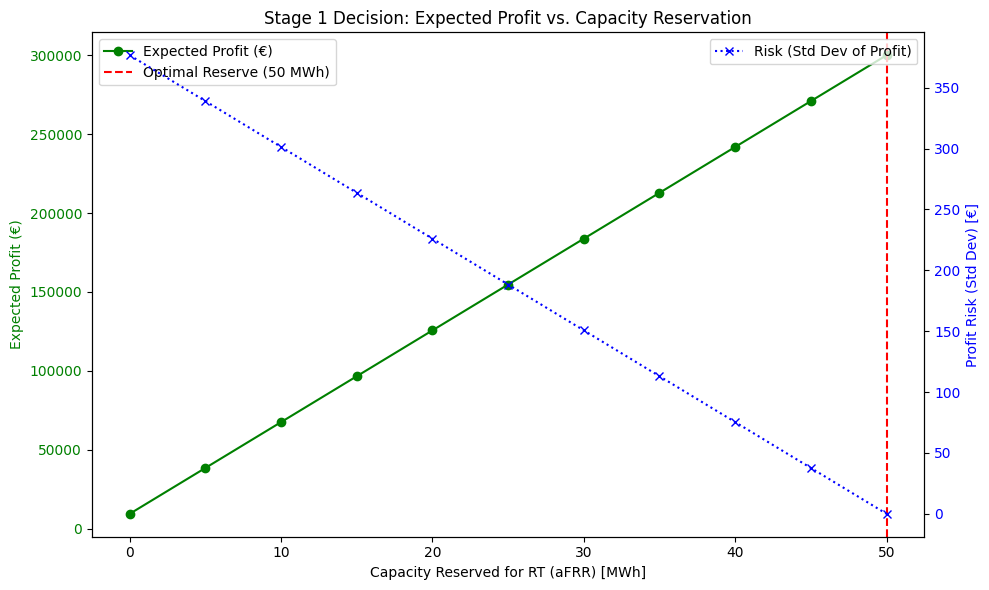

In [6]:
# --- 3. Graphical Analysis ---

# --- Plot 1: Probabilistic Price Scenarios ---
plt.figure(figsize=(12, 6))
# Filter for the first 5 RT price scenarios
scenarios_df.filter(regex='^RT_Price_s[0-4]$').plot(
    legend=False, ax=plt.gca(), alpha=0.6, linestyle='--', color='gray'
)
plt.plot(base_prices, label='Base DA Forecast', color='blue', linewidth=3)
plt.title(f'Probabilistic Real-Time Price Scenarios (N={NUM_SCENARIOS})')
plt.xlabel('Hour of Day')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.savefig('stochastic_scenarios.png')

# --- Plot 2: Expected Profit vs. Reserved Capacity (Stage 1 Decision) ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Expected Profit
ax1.plot(optimization_df['Reserved_Capacity_MWh'], 
         optimization_df['Expected_Profit'], 
         marker='o', color='green', label='Expected Profit (€)')
ax1.axvline(optimal_capacity_reserved, color='red', linestyle='--', 
            label=f'Optimal Reserve ({optimal_capacity_reserved:.0f} MWh)')
ax1.set_xlabel('Capacity Reserved for RT (aFRR) [MWh]')
ax1.set_ylabel('Expected Profit (€)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title('Stage 1 Decision: Expected Profit vs. Capacity Reservation')
ax1.legend(loc='upper left')

# Plot Profit Risk (Standard Deviation)
ax2 = ax1.twinx() 
ax2.plot(optimization_df['Reserved_Capacity_MWh'], 
         optimization_df['Std_Dev_Profit'], 
         marker='x', color='blue', linestyle=':', label='Risk (Std Dev of Profit)')
ax2.set_ylabel('Profit Risk (Std Dev) [€]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('stochastic_optimization_result.png')

print("\nAll stochastic optimization steps and graphs generated.")
print("Generated file: bess_stochastic_full.py")
print("Generated plots: stochastic_scenarios.png, stochastic_optimization_result.png")